In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict, List, Tuple
from pathlib import Path
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用
from tqdm import tqdm
from contextlib import contextmanager
from time import time
from collections import Counter

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import lightgbm as lgb

from mykaggle.metric.mse import rmsle
from mykaggle.util.ml_logger import MLLogger
from mykaggle.lib.lgbm_util import compute_importances, save_importances
from mykaggle.lib.pandas_util import change_column_name
from mykaggle.util.routine import fix_seed

sns.set_style('darkgrid')

In [2]:
settings = yaml.safe_load('''
name: '155_eda'
competition: atmacup8
seed: 1019
training:
    num_folds: 5
    num_rounds: 1000
    early_stopping_rounds: 100
    verbose_eval: 20
lgbm_params:
    objective: binary
    learning_rate: 0.05
    max_depth: -1
    num_leaves: 31
    colsample_bytree: .7
    metric: "None"
''')

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
fix_seed(settings['seed'])

In [4]:
datadir = Path('../data/')
ckptdir = Path('../ckpt/') / settings['name']
if not ckptdir.exists():
    ckptdir.mkdir()

In [5]:
df_train = pd.read_csv(datadir / 'id_train.csv')
df_test = pd.read_csv(datadir / 'id_test.csv')
df_submission = pd.read_csv(datadir / 'atmaCup8_sample-submission.csv')
df_train.shape, df_test.shape

((8359, 17), (8360, 12))

In [6]:
df_train.head().T

,0,1,2,3,4
Name,LEGO Batman: The Videogame,LEGO Indiana Jones: The Original Adventures,LEGO Batman: The Videogame,Combat,LEGO Harry Potter: Years 5-7
Platform,Wii,Wii,PSP,2600,Wii
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Warner Bros. Interactive Entertainment,LucasArts,Warner Bros. Interactive Entertainment,Atari,Warner Bros. Interactive Entertainment
NA_Sales,180,151,56,117,69
EU_Sales,97,61,44,7,42
JP_Sales,0,0,0,0,0
Other_Sales,28,21,27,1,12
Global_Sales,306,234,128,125,124


In [7]:
df_test.head().T

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4
Name,Hitman 2: Silent Assassin,Legacy of Kain: Soul Reaver,Metal Gear Solid 2: Substance,Silent Hill: Homecoming,Silent Hill: Homecoming
Platform,XB,PS,XB,X360,PS3
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Eidos Interactive,Eidos Interactive,Konami Digital Entertainment,Konami Digital Entertainment,Konami Digital Entertainment
Critic_Score,84,91,87,70,71
Critic_Count,23,17,28,54,41
User_Score,8,9,8.5,6.9,6.9
User_Count,19,132,39,180,143
Developer,Io Interactive,Crystal Dynamics,KCEJ,Double Helix Games,Double Helix Games


In [8]:
df_submission.head()

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Global_Sales
0,63.371815
1,63.371815
2,63.371815
3,63.371815
4,63.371815


In [9]:
df_train.loc[:, 'has_na_sales'] = df_train.loc[:, 'NA_Sales']  > 0
df_train.loc[:, 'has_eu_sales'] = df_train.loc[:, 'EU_Sales']  > 0
df_train.loc[:, 'has_jp_sales'] = df_train.loc[:, 'JP_Sales']  > 0
df_train.loc[:, 'has_other_sales'] = df_train.loc[:, 'Other_Sales']  > 0
# df_train.to_csv(datadir / 'country_train.csv', index=False)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
train = df_train.copy()
test = df_test.copy()
train['is_test'] = False
test['is_test'] = True
whole = pd.concat([train, test])

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
train_others = {
    'main': df_train.copy(),
    'another': df_test.copy()
}
test_others = {
    'main': df_test.copy(),
    'another': df_train.copy(),
}

# 国のセールス

In [12]:
sales = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

In [13]:
for s in sales:
    print(train.loc[:, s].value_counts().head())

0    2311
2     280
4     262
3     249
7     249
Name: NA_Sales, dtype: int64
0    3002
1     697
2     617
3     425
4     329
Name: EU_Sales, dtype: int64
0    4807
2     398
1     370
3     281
4     216
Name: JP_Sales, dtype: int64
0    3218
1    1691
2     812
3     473
4     340
Name: Other_Sales, dtype: int64


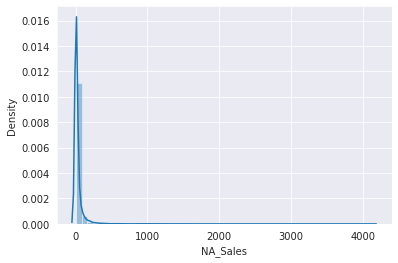

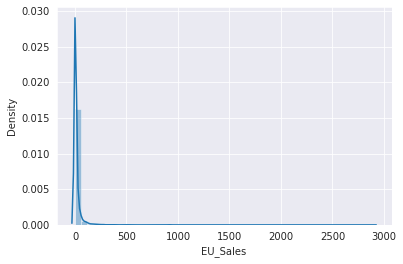

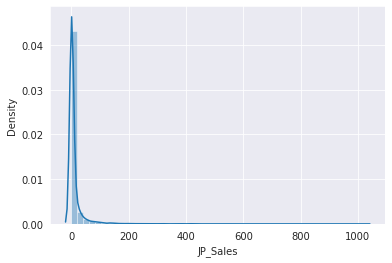

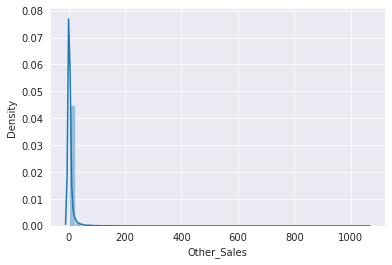

In [14]:
for s in sales:
    plt.figure()
    sns.distplot(train.loc[:, s])

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


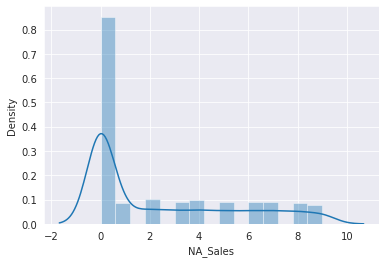

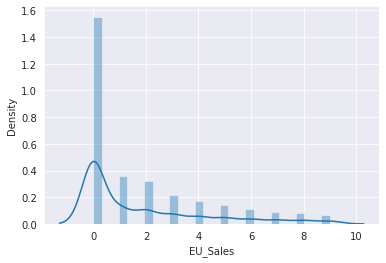

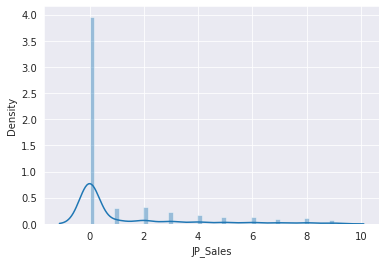

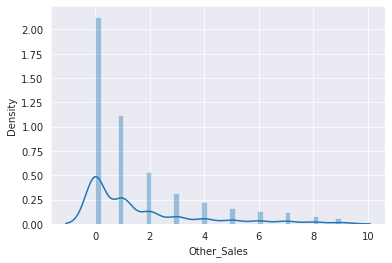

In [16]:
for s in sales:
    plt.figure()
    sns.distplot(train.loc[train.loc[:, s] < 10, s])

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


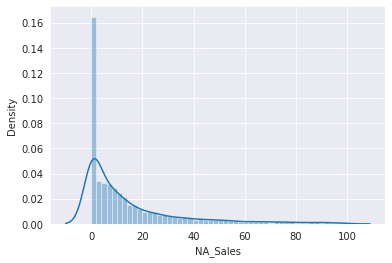

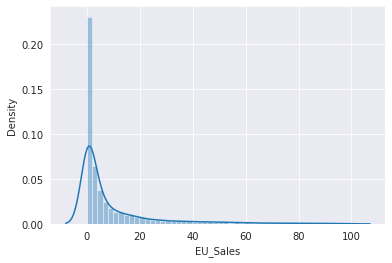

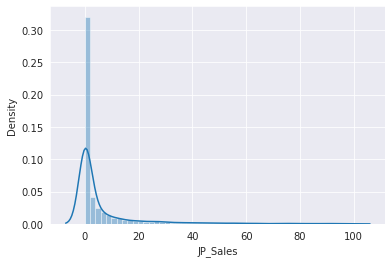

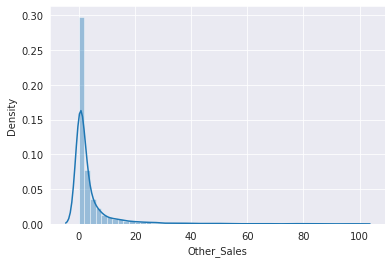

In [17]:
for s in sales:
    plt.figure()
    sns.distplot(train.loc[train.loc[:, s] < 100, s])

In [ ]:
train.loc[:, 'has_na_sales'] = train.loc[:, 'NA_Sales']  > 0
train.loc[:, 'has_eu_sales'] = train.loc[:, 'EU_Sales']  > 0
train.loc[:, 'has_jp_sales'] = train.loc[:, 'JP_Sales']  > 0
train.loc[:, 'has_other_sales'] = train.loc[:, 'Other_Sales']  > 0

In [ ]:
test['Name'] = test['Name'].fillna('Unknown')

In [ ]:
test[test['Name'].str.contains('jp')]

In [12]:
pred_sales = [
    '156_jp_sales',
    '157_na_sales',
    '158_eu_sales',
    '189_other_sales'
]

In [13]:
# test

In [14]:
basedir = Path('../ckpt/')
dfs = []
for pred in pred_sales:
    df = pd.read_csv(basedir / pred / (pred + '.csv'))
    dfs.append(df)
    
df_sales = pd.concat(dfs, axis=1)

In [16]:
df_sales

,has_jp_sales,has_na_sales,has_eu_sales,has_other_sales
0,0.024994,0.945987,0.911495,0.577279
1,0.531538,0.930108,0.946760,0.952127
2,0.136673,0.939683,0.914992,0.803058
3,0.454020,0.945443,0.971069,0.987863
4,0.600900,0.922788,0.963546,0.985004
...,...,...,...,...
8355,0.921956,0.253061,0.222631,0.052715
8356,0.902996,0.261210,0.244244,0.058970
8357,0.006802,0.181673,0.938938,0.046379
8358,0.011147,0.203807,0.892700,0.074630


In [17]:
df_test_sales = pd.concat([df_test, df_sales], axis=1)
df_test_sales.to_csv(datadir / 'country_prob_test2.csv', index=False)
df_test_sales.head()

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,id,has_jp_sales,has_na_sales,has_eu_sales,has_other_sales
0,Hitman 2: Silent Assassin,XB,NaN,Action,Eidos Interactive,84.0,23.0,8,19.0,Io Interactive,M,8359,0.024994,0.945987,0.911495,0.577279
1,Legacy of Kain: Soul Reaver,PS,NaN,Action,Eidos Interactive,91.0,17.0,9,132.0,Crystal Dynamics,T,8360,0.531538,0.930108,0.946760,0.952127
2,Metal Gear Solid 2: Substance,XB,NaN,Action,Konami Digital Entertainment,87.0,28.0,8.5,39.0,KCEJ,M,8361,0.136673,0.939683,0.914992,0.803058
3,Silent Hill: Homecoming,X360,NaN,Action,Konami Digital Entertainment,70.0,54.0,6.9,180.0,Double Helix Games,M,8362,0.454020,0.945443,0.971069,0.987863
4,Silent Hill: Homecoming,PS3,NaN,Action,Konami Digital Entertainment,71.0,41.0,6.9,143.0,Double Helix Games,M,8363,0.600900,0.922788,0.963546,0.985004


In [16]:
# training

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
basedir = Path('../ckpt/')
dfs = []
for pred in pred_sales:
    df = pd.read_csv(basedir / pred / ('train_' + pred + '.csv'))
    dfs.append(df)
    
df_sales = pd.concat(dfs, axis=1)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
df_sales

,has_jp_sales,has_na_sales,has_eu_sales,has_other_sales
0,0.022711,0.953149,0.930630,0.976365
1,0.022196,0.950683,0.942255,0.980895
2,0.020971,0.953247,0.909297,0.978061
3,0.021234,0.848037,0.889520,0.395130
4,0.021598,0.951913,0.922003,0.970370
...,...,...,...,...
8354,0.008785,0.207528,0.973386,0.130366
8355,0.007776,0.157787,0.937090,0.045985
8356,0.962374,0.139562,0.066496,0.008099
8357,0.927160,0.438481,0.288954,0.303362


In [20]:
has_sales = ['has_jp_sales', 'has_na_sales', 'has_eu_sales', 'has_other_sales']

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
df_train_sales = df_train.copy()
for c in has_sales:
    df_train_sales.loc[:, c] = df_sales.loc[:, c]
df_train_sales.to_csv(datadir / 'country_prob_train2.csv', index=False)

In [22]:
df_train_sales.tail()

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,...,Critic_Count,User_Score,User_Count,Developer,Rating,id,has_na_sales,has_eu_sales,has_jp_sales,has_other_sales
8354,Stellaris,PC,2016.0,Strategy,Paradox Interactive,0,4,0,0,4,...,57.0,8,569.0,Paradox Development Studio,NaN,8354,0.207528,0.973386,0.008785,0.413671
8355,Total War Attila: Tyrants & Kings,PC,2016.0,Strategy,Koch Media,0,1,0,0,1,...,NaN,NaN,NaN,NaN,NaN,8355,0.157787,0.937090,0.007776,0.078177
8356,Brothers Conflict: Precious Baby,PSV,2017.0,Action,Idea Factory,0,0,1,0,1,...,NaN,NaN,NaN,NaN,NaN,8356,0.139562,0.066496,0.962374,0.036658
8357,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017.0,Role-Playing,Sega,0,0,4,0,4,...,NaN,NaN,NaN,NaN,NaN,8357,0.438481,0.288954,0.927160,0.338038
8358,Phantasy Star Online 2 Episode 4: Deluxe Package,PSV,2017.0,Role-Playing,Sega,0,0,1,0,1,...,NaN,NaN,NaN,NaN,NaN,8358,0.224404,0.172157,0.941215,0.131783


In [34]:
df_tmp = []
for c in has_sales:
    df_tmp.append(df_train.loc[:, c] == (df_train_sales.loc[:, c] > 0.55))
df_tmp = pd.concat(df_tmp, axis=1)
np.mean(df_tmp.values)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9293575786577342

In [35]:
df_test_det = df_test_sales.copy()
for c in has_sales:
    df_test_det.loc[:, c] = df_test_sales.loc[:, c] > 0.55
df_test_det.to_csv(datadir / 'country_test.csv', index=False)
df_test_det.tail()

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,id,has_jp_sales,has_na_sales,has_eu_sales,has_other_sales
8355,SD Gundam G Generation Genesis,PSV,2016.0,Strategy,Namco Bandai Games,NaN,NaN,NaN,NaN,NaN,NaN,16714,True,False,False,False
8356,SD Gundam G Generation Genesis,PS4,2016.0,Strategy,Namco Bandai Games,NaN,NaN,NaN,NaN,NaN,NaN,16715,True,False,False,False
8357,Battle Worlds: Kronos,PC,2016.0,Strategy,Nordic Games,71.0,15.0,7.1,71.0,KING Art,NaN,16716,False,False,True,False
8358,Codename: Panzers Complete Collection,PC,2016.0,Strategy,Nordic Games,NaN,NaN,NaN,NaN,NaN,NaN,16717,False,False,True,False
8359,Imagine: Makeup Artist,DS,2020.0,Simulation,Ubisoft,NaN,NaN,tbd,NaN,Ubisoft,E,16718,False,True,False,False


In [ ]:
df_train_sales.loc[:, ['has_jp_sales', 'has_na_sales', 'has_eu_sales', 'has_other_sales']].head()

In [ ]:
df_train.loc[:, ['has_jp_sales', 'has_na_sales', 'has_eu_sales', 'has_other_sales']].head()

In [ ]:
tpr

In [36]:
df_train.loc[df_train['Name'].str.contains('Mario'), :]

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,...,Critic_Count,User_Score,User_Count,Developer,Rating,id,has_na_sales,has_eu_sales,has_jp_sales,has_other_sales
130,Mario Bros.,2600,1982.0,Platform,Atari,148,9,0,2,159,...,NaN,NaN,NaN,NaN,NaN,130,True,True,False,True
152,Mario Bros.,NES,1983.0,Platform,Nintendo,51,12,163,2,227,...,NaN,NaN,NaN,NaN,NaN,152,True,True,True,True
170,Super Mario Bros.,NES,1985.0,Platform,Nintendo,2908,358,681,77,4024,...,NaN,NaN,NaN,NaN,NaN,170,True,True,True,True
182,Super Mario Bros.: The Lost Levels,NES,1986.0,Platform,Nintendo,0,0,265,0,265,...,NaN,NaN,NaN,NaN,NaN,182,False,False,True,False
200,Super Mario Bros. 3,NES,1988.0,Platform,Nintendo,953,344,384,46,1728,...,NaN,NaN,NaN,NaN,NaN,200,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,Mario Tennis Ultra Smash,WiiU,2015.0,Sports,Nintendo,13,15,14,2,44,...,58.0,5.3,133.0,"Nintendo, Camelot Software Planning",E,8068,True,True,True,True
8107,Mario & Sonic at the Rio 2016 Olympic Games,3DS,2016.0,Action,Nintendo,5,21,25,2,53,...,NaN,NaN,NaN,NaN,NaN,8107,True,True,True,True
8111,Mario & Sonic at the Rio 2016 Olympic Games,WiiU,2016.0,Action,Nintendo,7,14,11,2,34,...,NaN,NaN,NaN,NaN,NaN,8111,True,True,True,True
8236,Mario Party: Star Rush,3DS,2016.0,Misc,Nintendo,8,13,8,2,30,...,37.0,6.8,16.0,"Nintendo, Nd Cube",E,8236,True,True,True,True


In [38]:
df_test.loc[df_test['Name'].fillna('NaN').str.contains('Mario'), :]

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,id
178,Mario Tennis,3DS,NaN,Sports,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8537
7329,Detective Conan: Marionette Symphony,3DS,2013.0,Adventure,Namco Bandai Games,NaN,NaN,NaN,NaN,NaN,NaN,15688


In [ ]:
df_test